In [2]:
import pandas as pd
import numpy as np
import os 
import shutil
from tqdm import tqdm
import random 

import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset , DataLoader

import albumentations as A
import albumentations.pytorch
from albumentations.core.transforms_interface import ImageOnlyTransform

from efficientnet_pytorch import EfficientNet
    
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import time
import cv2
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline  
%config InlineBackend.figure_format='retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# seed 고정 
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
seed_everything(42)

In [3]:
# hyperparameter 
img_path = 'input/data/train/images'
batch_size = 128
num_workers = 2
learning_rate = 0.001
epochs = 10
img_size = 256

In [4]:
df = pd.read_csv('preprocessing_data.csv')
df.drop(columns=['Unnamed: 0'], inplace = True)
df.head()

,path,id,mask,gender,age,label
0,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
1,input/data/train/images/000001_female_Asian_45...,000001,2,1,1,16
2,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
3,input/data/train/images/000001_female_Asian_45...,000001,0,1,1,4
4,input/data/train/images/000001_female_Asian_45...,000001,1,1,1,10


In [5]:
df[df['label'] == 14]

,path,id,mask,gender,age,label
2914,input/data/train/images/001038_male_Asian_60/n...,001038,2,0,2,14
2959,input/data/train/images/001043_male_Asian_60/n...,001043,2,0,2,14
2994,input/data/train/images/001047_male_Asian_60/n...,001047,2,0,2,14
3334,input/data/train/images/001101_male_Asian_60/n...,001101,2,0,2,14
3655,input/data/train/images/001152_male_Asian_60/n...,001152,2,0,2,14
...,...,...,...,...,...,...
13919,input/data/train/images/005033_male_Asian_60/n...,005033,2,0,2,14
13986,input/data/train/images/005045_male_Asian_60/n...,005045,2,0,2,14
14088,input/data/train/images/005071_male_Asian_60/n...,005071,2,0,2,14
14974,input/data/train/images/005418_male_Asian_60/n...,005418,2,0,2,14


In [6]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path , df ,transform = None):
        
        self.path = path
        self.df = df
        self.transform = transform
        
    def __getitem__(self,idx):
        image = cv2.imread(self.df['path'].iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']
        label = self.df['label'].iloc[idx]
        return image, label

    def __len__(self):
        return len(self.df)

In [7]:
# albumentation 사용 
train_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensor()
])

val_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensor()
])

In [8]:
train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3, shuffle = True )

train_dataset = CustomDataset(img_path , train_x , train_transforms)
val_dataset = CustomDataset(img_path , val_x , val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = False , num_workers = num_workers)

In [9]:
def train(epochs , train_loader, val_loader , model , criterion , optimizer , lr_scheduler = None):
    for epoch in range(epochs):
        ##################################### train ################################
        model.train()
        torch.cuda.empty_cache()
        loss_train_sum = 0
        acc_train_sum = 0
        
        for i , (img , target) in enumerate(tqdm(train_loader)):
            img = img.to(device)
            target = target.to(device)
            
            y_pred = model.forward(img)
            loss = criterion(y_pred, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train_sum += loss
            acc_train_sum += (y_pred.argmax(1) == target).sum().item()/ y_pred.shape[0]

        loss_train_avg = loss_train_sum / len(train_loader)
        acc_train_avg = acc_train_sum / len(train_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_train_avg:.3f}] acc : [{acc_train_avg : .3f}]")
        
        ##################################### eval ################################
        model.eval()
        
        loss_val_sum = 0
        acc_val_sum = 0
        
        for i , (img , target) in enumerate(tqdm(val_loader)):
            img = img.to(device)
            target = target.to(device)
            
            with torch.no_grad():
                y_pred = model.forward(img)
                loss = criterion(y_pred, target)
            
            loss_val_sum += loss
            acc_val_sum += (y_pred.argmax(1) == target).sum().item()/ batch_size
        
        loss_val_avg = loss_val_sum / len(val_loader)
        acc_val_avg = acc_val_sum / len(val_loader)
        print(f" epoch:[{epoch+1}/{epochs}] cost:[{loss_val_avg:.3f}] acc : [{acc_val_avg : .3f}]")
        
        if lr_scheduler : 
            lr_scheduler.step()
        

-------------------------------------------------------
1.Freeze 
- 결과 : 
- 우리 주제는 ImageNet과 다른 걸로! 

In [10]:
# # Model
# class BaseModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = EfficientNet.from_pretrained('efficientnet-b0')
#         self.model._fc = nn.Linear(1280,18)
        
#     def forward(self,x):
#         x = self.model(x)
#         return x
    
# # Model_FREEZE 
# def model_freeze(model):
#     for name, param in model.named_parameters():
#         if name not in ['model._fc.weight', 'model._fc.bias']:
#             param.requires_grad = False
#     return model

# Model_ft = BaseModel().to(device)
# Model = model_freeze(Model_ft)

# # freeze가 잘 됐는지 확인하기 
# # for i , param in Model.named_parameters():
# #     if not param.requires_grad:
# #         print(i, param)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(Model.parameters() , lr = learning_rate)

-----------------------------------------------------------
2. 새로운 모델 써보기 : EfficientNets 바꿔보기 
- B0 썼을 때 보다 성능이 떨어진다,,, 뭐지

In [11]:
# # RandomResizedCrop + Efficeiontnet-b2
# class BaseModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = EfficientNet.from_pretrained('efficientnet-b2')
#         self.model._fc = nn.Linear(1408,18)
        
#     def forward(self,x):
#         x = self.model(x)
#         return x
    
# Model = BaseModel().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(Model.parameters() , lr = learning_rate)

In [12]:
# train(epochs , train_loader , val_loader , Model, criterion , optimizer)

-----------------------------------------------------------
3. BalanceSampling 써보기  
- DynamicBalanceClassSampler 사용 + Epochs :30회 

In [13]:
from catalyst import data as data_catal

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, path , df ,transform = None):
        
        self.path = path
        self.df = df
        self.transform = transform
        
    def __getitem__(self,idx):
        image = cv2.imread(self.df['path'].iloc[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image) 
            image = augmented['image']
        label = self.df['label'].iloc[idx]
        return image, label

    def __len__(self):
        return len(self.df)
    
    def get_labels(self):
        return self.df['label']

In [14]:
# DynamicBalanceSampler
train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3, shuffle = True )

train_dataset = CustomDataset(img_path , train_x , train_transforms)
val_dataset = CustomDataset(img_path , val_x , val_transforms)

sampler = data_catal.DynamicBalanceSampler(labels=train_dataset.get_labels())

train_loader = torch.utils.data.DataLoader(train_dataset,sampler=sampler, batch_size= batch_size ,  num_workers = num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = False , num_workers = num_workers )


In [15]:
# BalanceBatchSampler
train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3, shuffle = True )

train_dataset = CustomDataset(img_path , train_x , train_transforms)
val_dataset = CustomDataset(img_path , val_x , val_transforms)

sampler = data_catal.BalanceBatchSampler(labels=train_dataset.get_labels() , p = 8 , k = 16)

train_loader = torch.utils.data.DataLoader(train_dataset,sampler=sampler, batch_size= sampler.batch_size ,  num_workers = num_workers)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = False , num_workers = num_workers )


----------------------------
얼굴 중심으로 crop하기


In [16]:
from typing import List, Union, Tuple, Sequence, Optional
        
def get_center_crop_coords(img , crop_height: int, crop_width: int, ratio : int):
    transformed_img = img.copy()
    height = img.shape[1]
    width = img.shape[0]
    delta = random.uniform(-ratio,ratio)
    y1 = int(np.round((1 + delta) * (height - crop_height) // 2))
    y2 = y1 + crop_height
    x1 = int(np.round((1 + delta) * (height - crop_width) // 2))
    x2 = x1 + crop_width
    return transformed_img[y1:y2 , x1:x2]

class CustomRandomCrop(ImageOnlyTransform):
    def __init__(self, height, width, ratio, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.crop_height = height
        self.crop_width = width
        self.ratio = ratio
        
    def apply(self, img, **params):
        return get_center_crop_coords(img,self.crop_height, self.crop_width , self.ratio )

In [17]:
# # albumentation 사용 
# # https://github.com/albumentations-team/albumentations/blob/a025bb6ed99532482d4c72ef1f6ef289f31b0a8f/albumentations/augmentations/crops/transforms.py
# # https://dacon.io/competitions/official/235697/codeshare/2360?page=3&dtype=recent
# train_transforms = A.Compose([
#     CustomRandomCrop(224,224,0.5),
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

# val_transforms = A.Compose([
#     A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
#     A.pytorch.transforms.ToTensor()
# ])

In [18]:
# train_x , val_x , train_y , val_y = train_test_split(df , df['label'] , test_size=0.3, shuffle = True )

# train_dataset = CustomDataset(img_path , train_x , train_transforms)
# val_dataset = CustomDataset(img_path , val_x , val_transforms)

# train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers )
# val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size , shuffle = True , num_workers = num_workers )

In [19]:
# # RandomResizedCrop + Efficeiontnet-b0
# class BaseModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.model = EfficientNet.from_pretrained('efficientnet-b0')
#         self.model._fc = nn.Linear(1280,18)
        
#     def forward(self,x):
#         x = self.model(x)
#         return x
    
# Model = BaseModel().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(Model.parameters() , lr = learning_rate)

-------------------------------------------------------
DarkNet Made by Me 써보기 


In [20]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels):
        super(ResidualBlock ,self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels // 2
        self.conv1x1 = nn.Conv2d(in_channels = self.in_channels,
                              out_channels = self.out_channels,
                               kernel_size = 1,
                               stride = 1,
                               bias = True
                              ) # 64d -> 1x1 32d

        self.conv3x3 = nn.Conv2d(in_channels = self.out_channels,
                              out_channels = self.in_channels,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1,
                               bias = True
                              ) # 32d -> 1x1, 64d
        self.bn1x1 = nn.BatchNorm2d(num_features = self.out_channels)
        self.bn3x3 = nn.BatchNorm2d(num_features =self.in_channels)
        self.relu = nn.LeakyReLU(True)
        
    def forward(self,x):
        base = x 
        x = self.conv1x1(x)
        x = self.bn1x1(x)
        x = self.relu(x)
        x = self.conv3x3(x)
        x = self.bn3x3(x)
        x = self.relu(x)
        return x + base 
        
        
class ConvS2(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(ConvS2 , self).__init__()
        self.conv= nn.Conv2d(in_channels = in_channels,
                                out_channels = out_channels,
                                kernel_size = 3,
                                stride = 2,
                                padding = 1,
                                bias = True)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.relu = nn.LeakyReLU(True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

        
class DarkModel(nn.Module):
    def __init__(self, num_class , ResBlock , ConvBlock):
        super(DarkModel,self).__init__()
        self.num_class = num_class

        self.conv0 = nn.Conv2d(in_channels = 3 , 
                                out_channels = 32,
                                kernel_size = 3,
                                stride = 1,
                                padding = 1,
                                bias = True)
        self.bn = nn.BatchNorm2d(num_features = 32)
        self.conv1 = ConvBlock(in_channels = 32 , out_channels =64)
        self.ResBlock1 = self.make_layer(ResBlock(in_channels = 64), 1)
        self.conv2 = ConvBlock(in_channels = 64 , out_channels = 128)  
        self.ResBlock2 = self.make_layer(ResBlock(in_channels = 128), 2)
        self.conv3 = ConvBlock(in_channels = 128 , out_channels = 256)
        self.ResBlock3 = self.make_layer(ResBlock(in_channels = 256), 8)
        self.conv4 = ConvBlock(in_channels = 256 , out_channels  =512)
        self.ResBlock4 =self.make_layer(ResBlock(in_channels = 512), 8)
        self.conv5 = ConvBlock(in_channels = 512 , out_channels = 1024)
        self.ResBlock5 = self.make_layer(ResBlock(in_channels = 1024), 4)
        self.relu = nn.LeakyReLU(True)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, self.num_class)



    def forward(self,x):
        x = self.conv0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.ResBlock1(x)
        x = self.conv2(x)
        x = self.ResBlock2(x)
        x = self.conv3(x)
        x = self.ResBlock3(x)
        x = self.conv4(x)
        x = self.ResBlock4(x)
        x = self.conv5(x)
        x = self.ResBlock5(x)
        x = self.GAP(x)
        x = x.squeeze()
        x = self.fc(x)
        return x         

    
    def make_layer(self,block,repeat):
        layers = []
        for i in range(repeat):
            layers.append(block)
        return nn.Sequential(*layers)
    

def DarkNet53(num_class):
    return DarkModel(num_class , ResidualBlock , ConvS2) 

In [21]:
Model = DarkNet53(18).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(Model.parameters() , lr = learning_rate)

In [22]:
train(epochs , train_loader , val_loader , Model, criterion , optimizer)

  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[1/10] cost:[2.475] acc : [ 0.266]


  0%|          | 0/104 [00:00<?, ?it/s]

 epoch:[1/10] cost:[2.379] acc : [ 0.210]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[2/10] cost:[2.002] acc : [ 0.350]


  0%|          | 0/104 [00:00<?, ?it/s]

 epoch:[2/10] cost:[2.334] acc : [ 0.252]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[3/10] cost:[1.819] acc : [ 0.416]


  0%|          | 0/104 [00:00<?, ?it/s]

 epoch:[3/10] cost:[2.231] acc : [ 0.253]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[4/10] cost:[1.713] acc : [ 0.448]


  0%|          | 0/104 [00:00<?, ?it/s]

 epoch:[4/10] cost:[2.220] acc : [ 0.275]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[5/10] cost:[1.638] acc : [ 0.467]


100%|██████████| 45/45 [00:16<00:00,  2.65it/s]


 epoch:[5/10] cost:[2.254] acc : [ 0.222]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[6/10] cost:[1.595] acc : [ 0.479]


  0%|          | 0/104 [00:00<?, ?it/s]

 epoch:[6/10] cost:[2.215] acc : [ 0.226]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[7/10] cost:[1.560] acc : [ 0.491]


  0%|          | 0/104 [00:00<?, ?it/s]

 epoch:[7/10] cost:[2.144] acc : [ 0.256]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[8/10] cost:[1.529] acc : [ 0.501]


100%|██████████| 45/45 [00:16<00:00,  2.68it/s]


 epoch:[8/10] cost:[2.141] acc : [ 0.254]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[9/10] cost:[1.496] acc : [ 0.510]


  0%|          | 0/104 [00:00<?, ?it/s]

 epoch:[9/10] cost:[2.160] acc : [ 0.225]


  0%|          | 0/45 [00:00<?, ?it/s]

 epoch:[10/10] cost:[1.469] acc : [ 0.517]


100%|██████████| 45/45 [00:16<00:00,  2.66it/s]


 epoch:[10/10] cost:[2.074] acc : [ 0.235]


In [23]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [24]:
test_dir = 'input/data/eval'

In [34]:
img_size = 256
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
                                    transforms.Resize((img_size, img_size)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False,
    batch_size = batch_size
)

# 모델을 정의합니다. (학습한 모델이 있다면 torch.load로 모델을 불러주세요!)
Model.eval()

# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.
all_predictions = []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        pred = Model(images)
        pred = pred.argmax(dim=-1)
        print(pred)
        all_predictions.extend(pred.cpu().numpy())
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'DarkNet_submission.csv'), index=False)
print('test inference is done!')

tensor([ 1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  0,  4,  0,  4,  4,  4,
         4,  4,  4,  1,  1,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  1,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  0,  4,  3,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  1,  4,  4,  4,  4,  4,  1,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  1,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4, 16], device='cuda:0')
tensor([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  1,  4,  4,  4,  4,  4,  4,  0,  4,
         4,  4,  4,  1,  4,  4,  4,  4, 16,  4,  4,  4,  3,  4,  4,  4,  4,  4,
         0,  4,  4,  4,  4,  4,  4, 16,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
      

In [76]:
def origin_get_center_crop_coords(height: int, width: int, crop_height: int, crop_width: int):
    y1 = (height - crop_height) // 2
    y2 = y1 + crop_height
    x1 = (width - crop_width) // 2
    x2 = x1 + crop_width
    return x1, y1, x2, y2


In [11]:
from typing import List, Union, Tuple, Sequence, Optional
from albumentations.core.transforms_interface import ImageOnlyTransform

        
def get_center_crop_coords(img , crop_height: int, crop_width: int, ratio : int):
    transformed_img = img.copy()
    height = img.shape[0]
    width = img.shape[1]
    #delta = random.uniform(-ratio,ratio)
    delta = 0.5
    y1 = int(np.round((1 + delta) * (height - crop_height) // 2))
    y2 = y1 + crop_height
    x1 = int(np.round((1 + delta) * (width - crop_width) // 2))
    x2 = x1 + crop_width
    return transformed_img[y1:y2 , x1:x2]

class CustomRandomCrop(ImageOnlyTransform):
    def __init__(self, height, width, ratio, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.crop_height = height
        self.crop_width = width
        self.ratio = ratio
        
    def apply(self, img, **params):
        return get_center_crop_coords(img,self.crop_height, self.crop_width , self.ratio )

In [12]:
# albumentation 사용 
# https://github.com/albumentations-team/albumentations/blob/a025bb6ed99532482d4c72ef1f6ef289f31b0a8f/albumentations/augmentations/crops/transforms.py
# https://dacon.io/competitions/official/235697/codeshare/2360?page=3&dtype=recent
train_transforms = A.Compose([
    CustomRandomCrop(224,224,0.5),
    A.ElasticTransform()
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensor()
])

val_transforms = A.Compose([
    A.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225]),
    A.pytorch.transforms.ToTensor()
])

SyntaxError: invalid syntax (<ipython-input-12-6bab0e54d388>, line 7)

In [8]:
def aug_random_imshow(img_paths, A_transform , B_transform , center_transforms):
    plt.figure(figsize=(15, 15))
    
    for idx in range(0,4):
        plt.subplot(4, 4, 4*idx+1)
        i = np.random.randint(len(img_paths))
        img = cv2.imread(img_paths[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f" original image", fontsize = 8)
        
        plt.subplot(4, 4, 4*idx+2)
        center_transformed = center_transforms(image=img)
        center_transformed_image = center_transformed["image"]
        plt.imshow(center_transformed_image)
        plt.title(f"just Center Crop image", fontsize = 8)

        plt.subplot(4, 4, 4*idx+3)
        transformed = A_transform(image=img)
        transformed_image = transformed["image"]
        plt.imshow(transformed_image)
        plt.title(f"Center + Random + Crop image : 1", fontsize = 8)
        
        plt.subplot(4, 4, 4*idx+4)
        transformed = B_transform(image=img)
        transformed_image = transformed["image"]
        plt.imshow(transformed_image)
        plt.title(f"Center + Random + Crop image : 0.5" , fontsize = 8)

    plt.show()

TypeError: forward() got an unexpected keyword argument 'image'

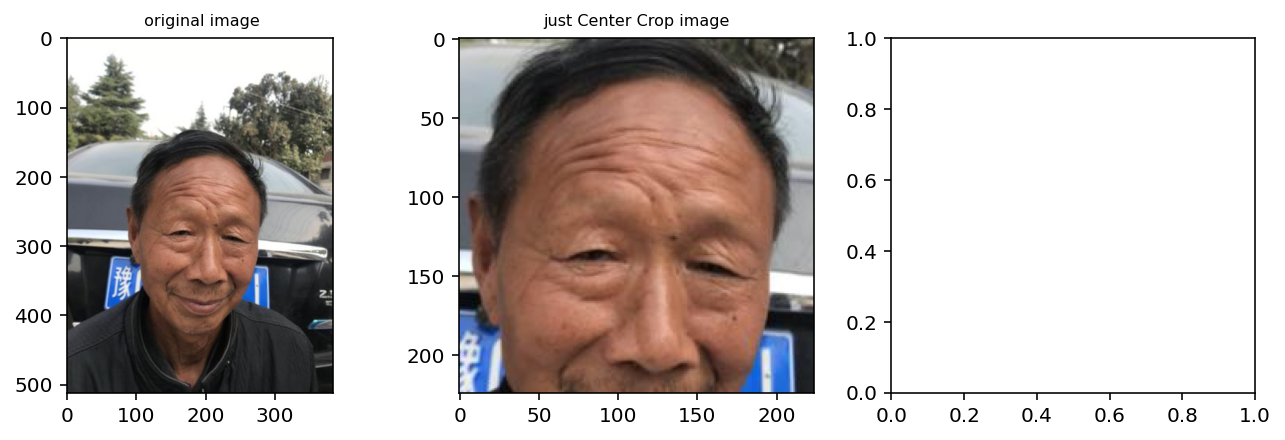

In [9]:
from glob import glob
img_path = glob('input/data/eval/images/*.jpg')

B_transforms = transforms.ColorJitter(contrast = 10)

center_transforms = A.CenterCrop(224, 224)
aug_random_imshow(img_path, B_transforms ,B_transforms ,center_transforms)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

colors_nude = ['#ffa4a9' , '#b0c2ff' , '#a6aea9' , '#99d6d3' , '#ffd166' , '#b1a5b4']
f , (ax1 , ax2 ) = plt.subplots(2, 1, figsize = (10,10))
sns.distplot(train_x['label'] , ax = ax1 , color = colors_nude[0])
ax1.set_title('Distribution of Train Dataset ')
sns.distplot(val_x['label'] , ax = ax2 , color = colors_nude[1])
ax2.set_title('Distribution of Val Dataset ')

In [ ]:
train_x['label'].value_counts().sort_index()

In [ ]:
val_x['label'].value_counts().sort_index()

In [ ]:
len(val_x)

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self,in_channels):
        super(ResidualBlock ,self).__init__()
        self.in_channels = in_channels
        self.out_channels = in_channels // 2
        self.conv1x1 = nn.Conv2d(in_channels = self.in_channels,
                              out_channels = self.out_channels,
                               kernel_size = 1,
                               stride = 1,
                               bias = True
                              ) # 64d -> 1x1 32d

        self.conv3x3 = nn.Conv2d(in_channels = self.out_channels,
                              out_channels = self.in_channels,
                               kernel_size = 3,
                               stride = 1,
                               padding = 1,
                               bias = True
                              ) # 32d -> 1x1, 64d
        self.bn1x1 = nn.BatchNorm2d(num_features = self.out_channels)
        self.bn3x3 = nn.BatchNorm2d(num_features =self.in_channels)
        self.relu = nn.LeakyReLU(True)
        
    def forward(self,x):
        base = x 
        x = self.conv1x1(x)
        x = self.bn1x1(x)
        x = self.relu(x)
        x = self.conv3x3(x)
        x = self.bn3x3(x)
        x = self.relu(x)
        return x + base 
        
        
class ConvS2(nn.Module):
    def __init__(self, in_channels , out_channels):
        super(ConvS2 , self).__init__()
        self.conv= nn.Conv2d(in_channels = in_channels,
                                out_channels = out_channels,
                                kernel_size = 3,
                                stride = 2,
                                padding = 1,
                                bias = True)
        self.bn = nn.BatchNorm2d(num_features = out_channels)
        self.relu = nn.LeakyReLU(True)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

        
class DarkModel(nn.Module):
    def __init__(self, num_class , ResBlock , ConvBlock):
        super(DarkModel,self).__init__()
        self.num_class = num_class

        self.conv0 = nn.Conv2d(in_channels = 3 , 
                                out_channels = 32,
                                kernel_size = 3,
                                stride = 1,
                                padding = 1,
                                bias = True)
        self.bn = nn.BatchNorm2d(num_features = 32)
        self.conv1 = ConvBlock(in_channels = 32 , out_channels =64)
        self.ResBlock1 = self.make_layer(ResBlock(in_channels = 64), 1)
        self.conv2 = ConvBlock(in_channels = 64 , out_channels = 128)  
        self.ResBlock2 = self.make_layer(ResBlock(in_channels = 128), 2)
        self.conv3 = ConvBlock(in_channels = 128 , out_channels = 256)
        self.ResBlock3 = self.make_layer(ResBlock(in_channels = 256), 8)
        self.conv4 = ConvBlock(in_channels = 256 , out_channels  =512)
        self.ResBlock4 =self.make_layer(ResBlock(in_channels = 512), 8)
        self.conv5 = ConvBlock(in_channels = 512 , out_channels = 1024)
        self.ResBlock5 = self.make_layer(ResBlock(in_channels = 1024), 4)
        self.relu = nn.LeakyReLU(True)
        self.GAP = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(1024, self.num_class)



    def forward(self,x):
        x = self.conv0(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.ResBlock1(x)
        x = self.conv2(x)
        x = self.ResBlock2(x)
        x = self.conv3(x)
        x = self.ResBlock3(x)
        x = self.conv4(x)
        x = self.ResBlock4(x)
        x = self.conv5(x)
        x = self.ResBlock5(x)
        x = self.GAP(x)
        x = x.squeeze()
        x = self.fc(x)
        return x         

    
    
    def make_layer(self,block,repeat):
        layers = []
        for i in range(repeat):
            layers.append(block)
        return nn.Sequential(*layers)
    

def DarkNet53(num_class):
    return DarkModel(num_class , ResidualBlock , ConvS2) 

In [ ]:
from torchsummary import summary
Model = DarkNet53(18).to(device)
summary(Model , (3,256,256))